In [1]:
!pip install folium
!pip install geocoder

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import itertools

#Libraries for plots
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
import geocoder

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#Library for k-mean algoritm
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [3]:
# The code was removed by Watson Studio for sharing.

Get boroughs of Hannover and corresponding postal code and average price in Dataframe

In [4]:
body = client_101a52750d8f41dd864c78d692a63eb5.get_object(Bucket='courseracapstone-donotdelete-pr-dkqvnxs4cmdwxj',Key='miete_plz_hannover.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_excel(io.BytesIO(body.read()))
df.head()

,Borough,Price,Code
0,Ahlem,"6,40",30453
1,Anderten,"6,85",30559
2,Badenstedt,"6,28","30453, 30455"
3,Bemerode,"6,72","30521, 30539, 30559"
4,Bornum,"5,80",30453


In [5]:
df['Price'] = df['Price'].str.replace(",",".").astype("float")
df = df.assign(PostalCode=df['Code'].str.split(',')).explode('Code')
df.PostalCode[df['PostalCode'].isnull()] = df['Code']
df = df.explode('PostalCode').set_index('Borough').reset_index()
df.drop(columns=['Code'],inplace=True)
df.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Borough,Price,PostalCode
0,Ahlem,6.40,30453
1,Anderten,6.85,30559
2,Badenstedt,6.28,30453
3,Badenstedt,6.28,30455
4,Bemerode,6.72,30521
5,Bemerode,6.72,30539
6,Bemerode,6.72,30559
7,Bornum,5.80,30453
8,Bothfeld,7.04,30655
9,Bothfeld,7.04,30657


Get Latitude and longitude of each borough

In [6]:
def get_cordinates(postalcode, borogh):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(postalcode, borogh))
        lat_lng_coords = g.latlng
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    return latitude, longitude

for rownr in range(0,len(df)):
    postalcode = df.loc[rownr, 'PostalCode'] 
    borogh = df.loc[rownr, 'Borough'] 
    lat, lon = get_cordinates(postalcode, borogh)
    df.loc[df.index[rownr], 'Latitude'] = lat
    df.loc[df.index[rownr], 'Longitude'] = lon
    
df.head()

,Borough,Price,PostalCode,Latitude,Longitude
0,Ahlem,6.40,30453,52.382135,9.663791
1,Anderten,6.85,30559,52.363262,9.855728
2,Badenstedt,6.28,30453,52.357484,9.690487
3,Badenstedt,6.28,30455,52.355059,9.670060
4,Bemerode,6.72,30521,52.345790,9.827210


Use FourSquare to explore the area around the boroughs

In [7]:
CLIENT_ID = 'JBSYFEOUB1PXPJ5NPB0OJYPGIZ1AAKOZLO4WNEOCKIH1ACZY' # your Foursquare ID
CLIENT_SECRET = '2EL3DG13UVU2GIUQEIROZJK4RNWXCL1I5T4R2XUOEWYPGEBP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
hannover_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [10]:
hannover_venues.shape

(1095, 7)

In [11]:
hannover_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ahlem,52.382135,9.663791,Lukullus,52.383930,9.664961,Greek Restaurant
1,Ahlem,52.382135,9.663791,Bäcker Göing,52.384274,9.664043,Bakery
2,Ahlem,52.382135,9.663791,Restaurant Plitvice,52.384388,9.663612,Restaurant
3,Ahlem,52.382135,9.663791,Schüler Bäckerei,52.379869,9.663824,Bakery
4,Ahlem,52.382135,9.663791,Seiltechnik Hannover,52.383462,9.669078,Sporting Goods Shop


Average price per square meter

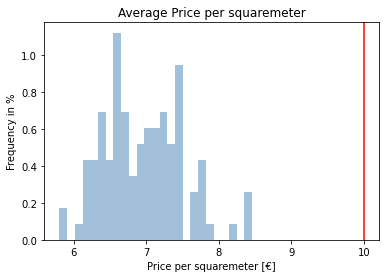

In [12]:
plt.ylabel('Frequency in %')
plt.xlabel('Price per squaremeter [€]')
plt.title('Average Price per squaremeter')

plt.hist(df['Price'], bins=25, density=True, alpha=0.5, 
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.axvline(10, 0,1, color='red')

In [13]:
df.describe()["Price"].to_frame()

,Price
count,109.000000
mean,6.955138
std,0.552556
min,5.800000
25%,6.550000
50%,6.950000
75%,7.330000
max,8.460000


In [14]:
### Create the ranges and colors for different pricing as shown in the table above
df['color'] = pd.cut(df['Price'], bins=4, 
                              labels=['blue', 'green', 'yellow', 'red'])
histprice = pd.cut(df['Price'], bins=4).value_counts().to_frame()
histprice.head()

,Price
"(6.465, 7.13]",41
"(7.13, 7.795]",39
"(5.797, 6.465]",24
"(7.795, 8.46]",5


In [15]:
# create map
Price_map = folium.Map(location=[52.37052, 9.73322], zoom_start=11)

#add circles in the colors associated with the defined range
for index, row in df.iterrows():
    folium.CircleMarker([row['Latitude'], 
                         row['Longitude']],
                         radius=5, 
                         color=row['color'], 
                         fill=True,
                         fill_color=row['color'],
                         fill_opacity=0.8
                       ).add_to(Price_map)

Price_map

Venues in the borouoghs of Hannover

In [16]:
#venues of interest
venueInterest = hannover_venues[(hannover_venues['Venue Category'].str.contains('Park')==True) | (hannover_venues['Venue Category'].str.contains('Lake')==True) | (hannover_venues['Venue Category'].str.contains('Forest')==True) | (hannover_venues['Venue Category'].str.contains('Playground')==True)
                                | (hannover_venues['Venue Category'].str.contains('Café')==True) | (hannover_venues['Venue Category'].str.contains('Coffee')==True) | (hannover_venues['Venue Category'].str.contains('Dessert')==True) | (hannover_venues['Venue Category'].str.contains('Tea')==True)
                                | (hannover_venues['Venue Category'].str.contains('Restaurant')==True) 
                                | (hannover_venues['Venue Category'].str.contains('Convenience')==True) | (hannover_venues['Venue Category'].str.contains('Drug')==True) | (hannover_venues['Venue Category'].str.contains('Pharmacy')==True) | (hannover_venues['Venue Category'].str.contains('Market')==True) | (hannover_venues['Venue Category'].str.contains('Supermarket')==True)]

#all other venues 
venueOther = hannover_venues[(hannover_venues['Venue Category'].str.contains('Park')==False) & (hannover_venues['Venue Category'].str.contains('Lake')==False) & (hannover_venues['Venue Category'].str.contains('Forest')==False) & (hannover_venues['Venue Category'].str.contains('Playground')==False)
                                & (hannover_venues['Venue Category'].str.contains('Café')==False) & (hannover_venues['Venue Category'].str.contains('Coffee')==False) & (hannover_venues['Venue Category'].str.contains('Dessert')==False) & (hannover_venues['Venue Category'].str.contains('Tea')==False)
                                & (hannover_venues['Venue Category'].str.contains('Restaurant')==False) 
                                & (hannover_venues['Venue Category'].str.contains('Convenience')==False) & (hannover_venues['Venue Category'].str.contains('Drug')==False) & (hannover_venues['Venue Category'].str.contains('Pharmacy')==False) & (hannover_venues['Venue Category'].str.contains('Market')==False) & (hannover_venues['Venue Category'].str.contains('Supermarket')==False)]

In [17]:
#Define dataframes that just contain the specific favourite venues
venuePark = hannover_venues[(hannover_venues['Venue Category'].str.contains('Park')==True) | (hannover_venues['Venue Category'].str.contains('Lake')==True) | (hannover_venues['Venue Category'].str.contains('Forest')==True) | (hannover_venues['Venue Category'].str.contains('Playground')==True)]
venueCoffee = hannover_venues[(hannover_venues['Venue Category'].str.contains('Café')==True) | (hannover_venues['Venue Category'].str.contains('Coffee')==True) | (hannover_venues['Venue Category'].str.contains('Dessert')==True) | (hannover_venues['Venue Category'].str.contains('Tea')==True)]
venueRestaurant = hannover_venues[(hannover_venues['Venue Category'].str.contains('Restaurant')==True)]
venueMarket = hannover_venues[(hannover_venues['Venue Category'].str.contains('Convenience')==True) | (hannover_venues['Venue Category'].str.contains('Drug')==True) | (hannover_venues['Venue Category'].str.contains('Pharmacy')==True) | (hannover_venues['Venue Category'].str.contains('Market')==True) | (hannover_venues['Venue Category'].str.contains('Supermarket')==True)]

In [18]:
# create map and display it
hannover_map = folium.Map(location=[52.37052, 9.73322], zoom_start=11)
incidents = folium.map.FeatureGroup()

for lat, lng, in zip(venueOther["Venue Latitude"], venueOther["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='grey',
        )
    )   

for lat, lng, in zip(venuePark["Venue Latitude"], venuePark["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='green',
        )
    )

for lat, lng, in zip(venueCoffee["Venue Latitude"], venueCoffee["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='orange',
        )
    )    

for lat, lng, in zip(venueRestaurant["Venue Latitude"], venueRestaurant["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='yellow',
        )
    )    

for lat, lng, in zip(venueMarket["Venue Latitude"], venueMarket["Venue Longitude"]):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3, # define how big you want the circle markers to be
            color='blue',
        )
    )   

hannover_map.add_child(incidents)
hannover_map

One hot encoding

In [19]:
#Step 1: One hot encoding of favourite venues 
venueInterest_onehot = pd.get_dummies(venueInterest[['Venue Category']], prefix="", prefix_sep="")

#Step 2: Smaller modifications 
########add neighborhood column back to dataframe

venueInterest_onehot['Neighborhood'] = venueInterest['Neighborhood'] 
########move neighborhood column to the first column
fixed_columns = [venueInterest_onehot.columns[-1]] + list(venueInterest_onehot.columns[:-1])
venueInterest_onehot = venueInterest_onehot[fixed_columns]

In [20]:
#Step 3: Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
venueInterest_grouped = venueInterest_onehot.groupby('Neighborhood').sum().reset_index()
venueInterest_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Bavarian Restaurant,Café,Chinese Restaurant,Coffee Roaster,Coffee Shop,...,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theme Park Ride / Attraction,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Ahlem,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Anderten,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Badenstedt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bemerode,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bornum,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


favorite venues

In [21]:
#Step 1: Create a reference dataframe, that contains the same indexing 
venueInterest_grouped_sum = pd.DataFrame()
venueInterest_grouped_sum = venueInterest_grouped.iloc[:, :1]

#Step 2: Create a separate dataframe for every category containing the sum of the specific category . 
#It is important to keep the indexing from the riginal dataframe

####parks
parks = venueInterest_grouped.filter(regex='Park|Forest|Lake|Playground',axis=1).sum(axis = 1).reset_index(name ='Parks')
parks.set_index(['index'], inplace = True)
####Cafés
coffees = venueInterest_grouped.filter(regex='Café|Coffee|Dessert|Tea',axis=1).sum(axis = 1).reset_index(name ='Cafés')
coffees.set_index(['index'], inplace = True)
####Grocery
markets = venueInterest_grouped.filter(regex='Grocery|Convenient|Drug|Pharmacy|market|Supermarket',axis=1).sum(axis = 1).reset_index(name ='Markets')
markets.set_index(['index'], inplace = True)
####Restaurants
restaurants = venueInterest_grouped.filter(regex='Restaurant',axis=1).sum(axis = 1).reset_index(name ='Restaurants')
restaurants.set_index(['index'], inplace = True)

#Step 3: Combine all of the dataframes based on their index
venueInterest_grouped_sum = pd.concat([venueInterest_grouped_sum, parks, coffees, markets, restaurants], axis=1)
venueInterest_grouped_sum

,Neighborhood,Parks,Cafés,Markets,Restaurants
0,Ahlem,1,0,1,2
1,Anderten,0,0,0,3
2,Badenstedt,1,0,1,1
3,Bemerode,1,0,2,2
4,Bornum,0,0,0,1
5,Bothfeld,0,0,1,5
6,Bult,1,0,1,10
7,Calenberger Neustadt,0,1,0,4
8,Davenstedt,0,0,0,1
9,Döhren,0,0,3,3


In [22]:
#build sum
venueInterest_grouped_sum['FavoriteScore'] = venueInterest_grouped_sum.sum(axis=1)

#normalize values
venueInterest_grouped_sum['FavoriteScore'] = venueInterest_grouped_sum['FavoriteScore']/venueInterest_grouped_sum["FavoriteScore"].sum()

#sort dataframe
venueInterest_grouped_sum.sort_values("FavoriteScore", ascending = False, inplace = True)
venueInterest_grouped_sum.reset_index(drop = True).head(10)

,Neighborhood,Parks,Cafés,Markets,Restaurants,FavoriteScore
0,Mitte,2,20,7,61,0.196507
1,List,0,8,14,24,0.100437
2,Südstadt,3,3,8,29,0.093886
3,Oststadt,0,7,3,30,0.087336
4,Nordstadt,2,8,4,17,0.067686
5,Groß-Buchholz,1,0,9,11,0.045852
6,Linden-Nord,0,4,2,11,0.037118
7,Vahrenwald,0,0,7,9,0.034934
8,Linden-Mitte,1,2,1,10,0.030568
9,Bult,1,0,1,10,0.026201


In [23]:
venueInterest_grouped_sum[(venueInterest_grouped_sum[['Parks', 'Cafés', 'Markets', 'Restaurants']] != 0).all(axis=1)]

,Neighborhood,Parks,Cafés,Markets,Restaurants,FavoriteScore
27,Mitte,2,20,7,61,0.196507
37,Südstadt,3,3,8,29,0.093886
30,Nordstadt,2,8,4,17,0.067686
20,Linden-Mitte,1,2,1,10,0.030568


All venues except favourite venues

In [24]:
#Step 1: One hot encoding of the venues
venueOther_onehot = pd.get_dummies(venueOther[['Venue Category']], prefix="", prefix_sep="")

#Step 2: Smaller modifications 
########add neighborhood column back to dataframe
venueOther_onehot['Neighborhood'] = venueOther['Neighborhood'] 

########move neighborhood column to the first column
fixed_columns = [venueOther_onehot.columns[-1]] + list(venueOther_onehot.columns[:-1])
venueOther_onehot = venueOther_onehot[fixed_columns]

In [25]:
#Step 3: Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
venueOther_grouped = venueOther_onehot.groupby('Neighborhood').mean().reset_index()
venueOther_grouped.head()

,Neighborhood,Zoo Exhibit,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Auto Garage,Automotive Shop,Bagel Shop,...,Theater,Tour Provider,Track,Tram Station,Trattoria/Osteria,Tree,Wine Bar,Wine Shop,Women's Store,Zoo
0,Ahlem,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Badenstedt,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.571429,0.0,0.0,0.0,0.000000,0.0,0.0
2,Bemerode,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.111111,0.0,0.0
3,Bornum,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,Bothfeld,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0


In [26]:
#Step 4: Define function that identifies the most common venues in the neigborhoods
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
#Step 5: Identify the most common venues in the neighboarhood using the function defned in step 4
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Common_venueOther = pd.DataFrame(columns=columns)
Common_venueOther['Neighborhood'] = venueOther_grouped['Neighborhood']

for ind in np.arange(venueOther_grouped.shape[0]):
    Common_venueOther.iloc[ind, 1:] = return_most_common_venues(venueOther_grouped.iloc[ind, :], num_top_venues)

Common_venueOther.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ahlem,Bakery,Sporting Goods Shop,Fruit & Vegetable Store,Friterie,Fountain,Food Court,Food & Drink Shop,Flower Shop,Field,Exhibit
1,Badenstedt,Tram Station,Hotel,Sports Club,Bakery,Zoo,Electronics Store,Fountain,Food Court,Food & Drink Shop,Flower Shop
2,Bemerode,Tram Station,Pizza Place,Wine Shop,Metro Station,Beer Store,IT Services,Shipping Store,Electronics Store,Food Court,Food & Drink Shop
3,Bornum,Big Box Store,Intersection,Hotel,Arts & Crafts Store,Exhibit,Friterie,Fountain,Food Court,Food & Drink Shop,Flower Shop
4,Bothfeld,Soccer Field,Discount Store,Bus Stop,Hotel,Tram Station,Ice Cream Shop,Steakhouse,Electronics Store,Food Court,Food & Drink Shop
5,Brink-Hafen,Auto Garage,Hardware Store,Zoo,Electronics Store,Friterie,Fountain,Food Court,Food & Drink Shop,Flower Shop,Field
6,Bult,Bakery,Tram Station,Theater,Miscellaneous Shop,Soccer Field,Gas Station,Spa,Sports Club,Concert Hall,Gym / Fitness Center
7,Calenberger Neustadt,Plaza,Beer Garden,Pizza Place,Monument / Landmark,Rock Club,Hotel,Fruit & Vegetable Store,Bike Shop,Pub,River
8,Davenstedt,Bus Stop,Soccer Field,Tram Station,Electronics Store,Friterie,Fountain,Food Court,Food & Drink Shop,Flower Shop,Field
9,Döhren,Bakery,Gastropub,Fruit & Vegetable Store,Friterie,Fountain,Food Court,Food & Drink Shop,Flower Shop,Field,Exhibit


Cluster Neighborhoods

In [28]:
#Step 1: One hot encoding of the venues
venues_onehot = pd.get_dummies(hannover_venues[['Venue Category']], prefix="", prefix_sep="")

#Step 2: Smaller modifications 
########add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = hannover_venues['Neighborhood'] 

########move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

In [29]:
#Step 3: Group the dataframe based on the neigborhood and calculate the mean of the specific venue within this neigborhood
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped.head(20)

,Neighborhood,Zoo Exhibit,African Restaurant,American Restaurant,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,Ahlem,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Anderten,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,Badenstedt,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,Bemerode,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.214286,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0
4,Bornum,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
5,Bothfeld,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.058824,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
6,Brink-Hafen,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
7,Bult,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.080000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
8,Calenberger Neustadt,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.041667,0.0,0.0,0.0,0.000000,0.0,0.0
9,Davenstedt,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.200000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [30]:
#Step 1: Set number of clusters
kclusters = 8

#Step 2: Drop neigborhood column as it should not be considered in the clustering
venues_grouped_clustering = venues_grouped.drop(['Neighborhood'], 1)

#Step 3: Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)
kmeans.labels_

array([7, 0, 3, 3, 6, 6, 5, 6, 6, 0, 7, 3, 6, 0, 6, 0, 7, 6, 0, 6, 3, 1,
       6, 6, 6, 6, 1, 1, 6, 6, 3, 7, 4, 6, 3, 6, 3, 3, 3, 1, 6, 3, 6, 7,
       6, 0, 7, 6, 2, 6], dtype=int32)

In [31]:
#Step 4: Add clustering labels to dataframe
venues_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

#Step 5: Merge dataframe to get the latitude and longitude for all of 
#the neighborhoods
merged = df

#rename columns as we will merge the dataframes based on the neighborhoods
df.rename(columns={'Borough':'Neighborhood'}, inplace = True)

#merge dataframes
merged = merged.join(venues_grouped.set_index('Neighborhood'), on='Neighborhood')
merged

,Neighborhood,Price,PostalCode,Latitude,Longitude,color,Cluster Labels,Zoo Exhibit,African Restaurant,American Restaurant,...,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,Ahlem,6.40,30453,52.382135,9.663791,blue,7.0,0.00,0.0,0.0,...,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
1,Anderten,6.85,30559,52.363262,9.855728,green,0.0,0.00,0.0,0.0,...,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
2,Badenstedt,6.28,30453,52.357484,9.690487,blue,3.0,0.00,0.0,0.0,...,0.400000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
3,Badenstedt,6.28,30455,52.355059,9.670060,blue,3.0,0.00,0.0,0.0,...,0.400000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
4,Bemerode,6.72,30521,52.345790,9.827210,green,3.0,0.00,0.0,0.0,...,0.214286,0.0,0.00,0.0,0.0,0.0,0.0,0.071429,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Wettbergen,6.33,30457,52.330482,9.694555,blue,7.0,0.00,0.0,0.0,...,0.200000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
105,Wülfel,6.39,30519,52.328060,9.779705,blue,6.0,0.00,0.0,0.0,...,0.055556,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
106,Wülferode,7.06,30539,52.329012,9.851174,green,2.0,0.00,0.0,0.0,...,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
107,Zoo,8.46,30175,52.379667,9.767583,red,6.0,0.25,0.0,0.0,...,0.050000,0.0,0.05,0.0,0.0,0.0,0.0,0.000000,0.0,0.05


In [32]:
merged[merged['Cluster Labels']==7]

,Neighborhood,Price,PostalCode,Latitude,Longitude,color,Cluster Labels,Zoo Exhibit,African Restaurant,American Restaurant,...,Tram Station,Trattoria/Osteria,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Zoo
0,Ahlem,6.40,30453,52.382135,9.663791,blue,7.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,Döhren,7.08,30519,52.338523,9.767108,green,7.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,Kirchrode,7.86,30559,52.358117,9.820036,red,7.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,Mühlenberg,5.82,30457,52.343391,9.691676,blue,7.0,0.0,0.0,0.0,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Vinnhorst,6.21,30165,52.414562,9.718411,blue,7.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,Vinnhorst,6.21,30419,52.419260,9.704925,blue,7.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,Wettbergen,6.33,30457,52.330482,9.694555,blue,7.0,0.0,0.0,0.0,...,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
merged = merged[merged['Cluster Labels'].notnull()]

In [35]:
#Create Folium Map
map_clusters = folium.Map(location=[52.37052, 9.73322], zoom_start=11)

#Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:
df_bestchoice = df[df["Neighborhood"] == "Mitte"].groupby("PostalCode").mean()
df_bestchoice.iloc[:,0].to_frame()

,Price
PostalCode,
30159,7.33
30161,7.33
30167,7.33
30169,7.33
30171,7.33
30175,7.33
